# 微调

在前面的一些章节中，我们介绍了如何在只有6万张图像的Fashion-MNIST训练数据集上训练模型。我们还描述了学术界当下使用最广泛的大规模图像数据集ImageNet，它有超过1,000万的图像和1,000类的物体。然而，我们平常接触到数据集的规模通常在这两者之间。

假设我们想从图像中识别出不同种类的椅子，然后将购买链接推荐给用户。一种可能的方法是先找出100种常见的椅子，为每种椅子拍摄1,000张不同角度的图像，然后在收集到的图像数据集上训练一个分类模型。这个椅子数据集虽然可能比Fashion-MNIST数据集要庞大，但样本数仍然不及ImageNet数据集中样本数的十分之一。这可能会导致适用于ImageNet数据集的复杂模型在这个椅子数据集上过拟合。同时，因为数据量有限，最终训练得到的模型的精度也可能达不到实用的要求。

为了应对上述问题，一个显而易见的解决办法是收集更多的数据。然而，收集和标注数据会花费大量的时间和资金。例如，为了收集ImageNet数据集，研究人员花费了数百万美元的研究经费。虽然目前的数据采集成本已降低了不少，但其成本仍然不可忽略。

另外一种解决办法是应用迁移学习（transfer learning），将从源数据集学到的知识迁移到目标数据集上。例如，虽然ImageNet数据集的图像大多跟椅子无关，但在该数据集上训练的模型可以抽取较通用的图像特征，从而能够帮助识别边缘、纹理、形状和物体组成等。这些类似的特征对于识别椅子也可能同样有效。

本节我们介绍迁移学习中的一种常用技术：微调（fine tuning）。如图9.1所示，微调由以下4步构成。

1. 在源数据集（如ImageNet数据集）上预训练一个神经网络模型，即源模型。
2. 创建一个新的神经网络模型，即目标模型。它复制了源模型上除了输出层外的所有模型设计及其参数。我们假设这些模型参数包含了源数据集上学习到的知识，且这些知识同样适用于目标数据集。我们还假设源模型的输出层跟源数据集的标签紧密相关，因此在目标模型中不予采用。
3. 为目标模型添加一个输出大小为目标数据集类别个数的输出层，并随机初始化该层的模型参数。
4. 在目标数据集（如椅子数据集）上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的。

![微调](finetune.svg)

当目标数据集远小于源数据集时，微调有助于提升模型的泛化能力。


## 热狗识别

接下来我们来实践一个具体的例子：热狗识别。我们将基于一个小数据集对在ImageNet数据集上训练好的ResNet模型进行微调。该小数据集含有数千张包含热狗和不包含热狗的图像。我们将使用微调得到的模型来识别一张图像中是否包含热狗。

首先，导入实验所需的包或模块。

In [1]:
import tensorflow as tf
import numpy as np

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

### 获取数据集

我们使用的热狗数据集是从网上抓取的，它含有1400张包含热狗的正类图像，和同样多包含其他食品的负类图像。各类的1000张图像被用于训练，其余则用于测试。

我们首先将压缩后的数据集下载到路径`../data`之下，然后在该路径将下载好的数据集解压，得到两个文件夹`hotdog/train`和`hotdog/test`。这两个文件夹下面均有`hotdog`和`not-hotdog`两个类别文件夹，每个类别文件夹里面是图像文件。

In [0]:
import os
import zipfile
import wget

def download_data():
    data = os.getcwd()+'/data'
    base_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/'
    wget.download(
        base_url + 'gluon/dataset/hotdog.zip',
        data)

    with zipfile.ZipFile('data', 'r') as z:
        z.extractall(os.getcwd())

download_data()

我们创建两个`tf.keras.preprocessing.image.ImageDataGenerator`实例来分别读取训练数据集和测试数据集中的所有图像文件。
这里我们将训练集图片全部处理为高和宽均为224像素的输入。此外，我们对RGB（红、绿、蓝）三个颜色通道的数值做标准化。

In [3]:
import pathlib
train_dir = 'hotdog/train'
test_dir = 'hotdog/test'
train_dir = pathlib.Path(train_dir)
train_count = len(list(train_dir.glob('*/*.jpg')))
test_dir = pathlib.Path(test_dir)
test_count = len(list(test_dir.glob('*/*.jpg')))

CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name != 'LICENSE.txt' and item.name[0] != '.'])
CLASS_NAMES

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_data_gen = image_generator.flow_from_directory(directory=str(train_dir),
                                                    batch_size=BATCH_SIZE,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    shuffle=True,
                                                    classes = list(CLASS_NAMES))

test_data_gen = image_generator.flow_from_directory(directory=str(test_dir),
                                                    batch_size=BATCH_SIZE,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    shuffle=True,
                                                    classes = list(CLASS_NAMES))

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


下面我们随机取1个batch的图片然后绘制出来。

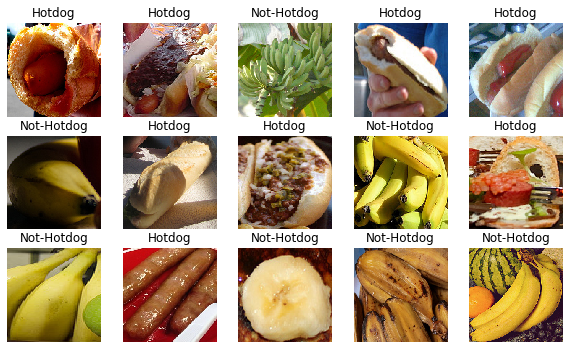

In [4]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
        
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

### 定义和初始化模型

我们使用在ImageNet数据集上预训练的ResNet-50作为源模型。这里指定`weights='imagenet'`来自动下载并加载预训练的模型参数。在第一次使用时需要联网下载模型参数。

In [5]:
ResNet50 = tf.keras.applications.resnet_v2.ResNet50V2(weights='imagenet', input_shape=(224,224,3))
for layer in ResNet50.layers:
    layer.trainable = False
net = tf.keras.models.Sequential()
net.add(ResNet50)
net.add(tf.keras.layers.Flatten())
net.add(tf.keras.layers.Dense(2, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


接下来我们使用之前定义好的ImageGenerator将训练集图片送入ResNet50进行训练。

In [6]:
net.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history = net.fit_generator(
                    train_data_gen,
                    steps_per_epoch=10,
                    epochs=3,
                    validation_data=test_data_gen,
                    validation_steps=10
                    )

Epoch 1/3
10/10 [==============================] - 8s 791ms/step - loss: 0.6929 - acc: 0.4969 - val_loss: 0.6939 - val_acc: 0.4531
Epoch 2/3
10/10 [==============================] - 2s 249ms/step - loss: 0.6919 - acc: 0.5125 - val_loss: 0.6888 - val_acc: 0.4719
Epoch 3/3
10/10 [==============================] - 2s 240ms/step - loss: 0.6914 - acc: 0.5906 - val_loss: 0.6836 - val_acc: 0.7875


可以看到，具有预训练参数的ResNet50经过3个epoch后val_acc达到了0.78。

作为对比，我们定义一个相同的模型，但将它的所有模型参数都初始化为随机值。由于整个模型都需要从头训练，我们可以使用较大的学习率。

In [7]:
ResNet50_scratch = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(224,224,3))
net_scratch = tf.keras.models.Sequential()
net_scratch.add(ResNet50_scratch)
net_scratch.add(tf.keras.layers.Flatten())
net_scratch.add(tf.keras.layers.Dense(2, activation='softmax'))

net_scratch.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = net_scratch.fit_generator(
                    train_data_gen,
                    steps_per_epoch=10,
                    epochs=3,
                    validation_data=test_data_gen,
                    validation_steps=10
                    )

Epoch 1/3
10/10 [==============================] - 17s 2s/step - loss: 0.6787 - acc: 0.7063 - val_loss: 0.6937 - val_acc: 0.5250
Epoch 2/3
10/10 [==============================] - 6s 640ms/step - loss: 0.6567 - acc: 0.8092 - val_loss: 0.6937 - val_acc: 0.5094
Epoch 3/3
10/10 [==============================] - 5s 472ms/step - loss: 0.6784 - acc: 0.6156 - val_loss: 0.6956 - val_acc: 0.5125


可以看到，没有初始化参数的模型收敛速度更慢。

所以，微调的模型因为参数初始值更好，往往在相同迭代周期下取得更高的精度。

## 小结


* 迁移学习将从源数据集学到的知识迁移到目标数据集上。微调是迁移学习的一种常用技术。
* 目标模型复制了源模型上除了输出层外的所有模型设计及其参数，并基于目标数据集微调这些参数。而目标模型的输出层需要从头训练。
* 一般来说，微调参数会使用较小的学习率，而从头训练输出层可以使用较大的学习率。